# **Open** **Cities** **AI**: **Segmenting** **Buildings** **for** **Disaster** **Resilience** 



# > **Pre Processing**




Importing necessary libraries

In [0]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
#!pip install solaris
!pip install rio-tiler

In [0]:
#double install
!pip install git+https://github.com/CosmiQ/solaris/@dev

In [0]:
!pip install torch==1.4.0 torchvision

In [0]:
!pip install supermercado

In [0]:
# restarts runtime
import os
os._exit(00)

Creating Data Path

In [0]:
import solaris as sol
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os


# Folder Setup
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
img_path = data_dir/'images-512'
mask_path = data_dir/'masks-512'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

In [0]:
!pip install pystac

In [0]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import solaris as sol
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

If you are only going to read from another source, e.g. HTTP, you could only replace the read method. For example, using the requests library:

In [0]:
from urllib.parse import urlparse
import requests
from pystac import STAC_IO
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)
STAC_IO.read_text_method = my_read_method

In [0]:
# load our training catalogs
train1_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/catalog.json')

cols = {cols.id:cols for cols in train1_cat.get_children()}

If the catalog file from driven data has been deleted then download all tier_1
and run this code . Uncomment lines

If you choose this step then running using none accelerator .At the end you must save the data file because for the training step the runtime will change to  gpu.

In [0]:

#!wget https://drivendata-public-assets.s3.amazonaws.com/train_tier_1.tgz

#!tar -xf train_tier_1.tgz
#!rm train_tier_1.tgz

#train1_cat = Catalog.from_file('train_tier_1/catalog.json')
#cols = {cols.id:cols for cols in train1_cat.get_children()}

In [0]:
# Get a list of the possible areas ('scenes) and ids
areas = []
for c in cols:
  itms = [x for x in cols[c].get_all_items()]
  for i, id in enumerate(itms):
    if i % 2 == 0 and i+1 < len(itms):
      areas.append((c, itms[i].id, itms[i+1].id))
print(areas)

For simplicity of demonstration, we'll create training and validation data from a single drone image (in cloud-optimized geoTIFF format) and its accompanying ground-truth labels of manually traced building outlines (in GeoJSON format).

In [0]:
  area = 'acc'
  img_id = 'ca041a'
  label_id='ca041a-labels'
  zoom_level = 19
  tile_size = 512

  one_item = cols[area].get_item(id=img_id)
  print(one_item)

  # Load labels shapefile
  lab = cols[area].get_item(id=label_id)
  gdf = gpd.read_file(lab.make_asset_hrefs_absolute().assets['labels'].href)
  # get the geometries from the geodataframe
  all_polys = gdf.geometry

  # Get outlines as polygons
  polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0])
  polygon = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polygon_geom])   

  # Tile at zoom_level
  polygon['geometry'].to_file(img_id+'.geojson', driver='GeoJSON')
  !cat {img_id}.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > {img_id}{zoom_level}tiles.geojson

In [0]:
  # Load tiles
  tiles = gpd.read_file(f'{img_id}{zoom_level}tiles.geojson')
  tiles.head()

In [0]:
  # Add a convenience column
  tiles['xyz'] = tiles.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tiles['xyz'] = [[int(q) for q in p] for p in tiles['xyz']]
  tiles.head()

In [0]:
  # IMG URL
tif_url = one_item.assets['image'].href
if tif_url.startswith("./"):
    tif_url = '/'.join(one_item.to_dict()['links'][1]['href'].split("/")[:-1])+tif_url[1:]
tile, mask = rt_main.tile(tif_url, *tiles.iloc[22]['xyz'], tilesize=tile_size)
plt.imshow(np.moveaxis(tile,0,2))


In [0]:
# preemptively fix and merge any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 

# Sources:
# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

In [0]:
all_polys = cleanup_invalid_geoms(all_polys)

In [0]:
tile_poly = tiles.iloc[22]['geometry']
print(tile_poly.bounds)
tile_poly

In [0]:
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

In [0]:
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
cropped_polys_gdf.plot()

In [0]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html

fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(fbc_mask[:,:,0])
ax2.imshow(fbc_mask[:,:,1])
ax3.imshow(fbc_mask[:,:,2])


Now that we've successfully loaded one tile image from COG with rio-tiler and created its 3-channel RGB mask with solaris, let's generate our full training and validation datasets.

The Coordinate Reference System (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.


In [0]:
from pyproj import CRS        
crs = CRS("EPSG:32633") # or 32631 or 4326

Declaring methods, creating 512 x 512 images from tif.

In [0]:
def save_area_id_images_2(area = 'acc', img_id = 'ca041a', label_id='ca041a-labels', zoom_level = 19, tile_size = 256):

  # The item
  one_item = cols[area].get_item(id=img_id)

  # Load labels shapefile
  lab = cols[area].get_item(id=label_id)
  gdf = gpd.read_file(lab.make_asset_hrefs_absolute().assets['labels'].href)

  # Get the geometries from the geodataframe
  all_polys = gdf.geometry

  # Get outlines as polygons
  polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0])
  polygon = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polygon_geom])   

  # Tile at zoom_level
  polygon['geometry'].to_file(img_id+'.geojson', driver='GeoJSON')
  !cat {img_id}.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > {img_id}{zoom_level}tiles.geojson

  # Load tiles
  tiles = gpd.read_file(f'{img_id}{zoom_level}tiles.geojson')

  # Add a convenience column
  tiles['xyz'] = tiles.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tiles['xyz'] = [[int(q) for q in p] for p in tiles['xyz']]

  # IMG URL
  tif_url = one_item.assets['image'].href

  # Sometimes it's just ./id.tif - add full path (should maybe use make_asset_hrefs_absolute instead!!)
  if tif_url.startswith("./"):
    tif_url = '/'.join(one_item.to_dict()['links'][1]['href'].split("/")[:-1])+tif_url[1:]

  print("TIF URL:", tif_url)

  print("Number of tiles:", len(tiles))
  return tiles , all_polys ,tif_url

In [0]:
import skimage
from tqdm import tqdm

In [0]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
    
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

In [0]:
def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
  
  # 3-channel RGB mask 
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

Make and save all the image and mask tiles that have been loaded one tile image from COG with rio-tiler and created its 3-channel RGB mask with solaris.


In [0]:
for area , img_id , label in areas :
  print(area,img_id , label)

  tiles_gdf , all_polys , tif_url = save_area_id_images_2(area = area, img_id = img_id, label_id=label, zoom_level = 19, tile_size = 512)
  tile_size = 512
  all_polys = cleanup_invalid_geoms(all_polys)

  # Set display variable True in order to check the results 
  for idx, tile in tqdm(tiles_gdf.iterrows()):
    save_tile_img(tif_url, tile['xyz'], tile_size, save_path=img_path, prefix=f'{area}_{img_id}_{idx}_', display=False)
    tile_poly = tile['geometry']
    save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'{area}_{img_id}_{idx}_', display=False)


Run the cells bellow just in case you desire to    



1.   save the dataset in drive as zip
2.   extract tar.gz dataset file (if you upload it from another source e.g Drive)





Do not forget to uncomment lines




In [0]:
#!tar -czf data.tar.gz data
#!cp data.tar.gz /content/drive/My\ Drive/
#from google.colab import drive
#drive.mount('/content/drive') 

In [0]:
# Unzip - this gives a folder called 'data'
#!tar -xvf data.tar.gz; rm data.tar.gz
#!ls data



# > **Train**




Running using the gpu runtime

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import*

In [0]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Mar  6 15:14:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-

In [0]:
import glob
import pandas as pd

# List of images
ims = glob.glob('data/images-512/*.png')
df = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims],
    'valid':False
})
# Add some useful columns
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[1])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[0].split("/")[-1])

# View
df.head()

,img_path,mask_path,valid,scene_id,area
0,data/images-256/znz_bd5c14_271_19_319469_27080...,data/masks-256/znz_bd5c14_271_19_319469_270806...,False,bd5c14,znz
1,data/images-256/znz_bc32f1_1422_19_319460_2708...,data/masks-256/znz_bc32f1_1422_19_319460_27087...,False,bc32f1,znz
2,data/images-256/znz_aee7fd_502_19_319408_27077...,data/masks-256/znz_aee7fd_502_19_319408_270772...,False,aee7fd,znz
3,data/images-256/znz_aee7fd_1573_19_319413_2707...,data/masks-256/znz_aee7fd_1573_19_319413_27079...,False,aee7fd,znz
4,data/images-256/znz_06f252_234_19_319427_27072...,data/masks-256/znz_06f252_234_19_319427_270725...,False,06f252,znz


In [0]:
# How many ims for each area?
df.groupby('area').count()['scene_id']

area
acc     1619
dar     3631
kam      239
mon      444
nia      160
ptn      400
znz    17114
Name: scene_id, dtype: int64

In [0]:
# Let's use ptn as a valid set. Can also split randomly
df.loc[df.area == 'ptn', 'valid'] = True

In [0]:
import torch

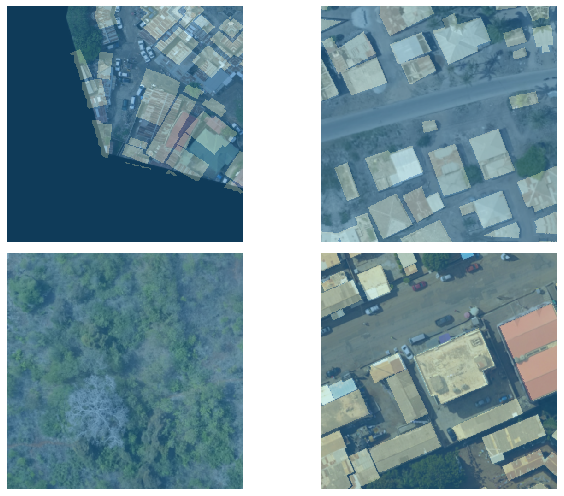

In [0]:
# Override open method of SegmentationLabelList since our masks are 0 for class 0, 255 for class 1 (so need div=True)
def my_open(self, fn): return open_mask(fn, div=True)
SegmentationLabelList.open = my_open

# Load the data from the dataframe
np.random.seed(42)
src = (SegmentationItemList.from_df(path='', df=df, cols='img_path')
       .split_from_df(col='valid')
       .label_from_df(cols='mask_path', classes=["building", "not"]))

data = (src.transform(get_transforms(), size=512, tfm_y=True)
        .databunch(bs=8) # Change batch size if you're having memory issues
        .normalize(imagenet_stats))

# Check out a batch
data.show_batch(2, figsize=(10,7))

In [0]:
import pdb

In [0]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=0)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=True, one_ch:int=0)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [0]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)
metrics = [acc_thresh_multich, dice_multich]

In [0]:

def dice_loss(input, target):
    # pdb.set_trace()
    smooth = 1
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)


In [0]:

#iou=partial(dice,iou =True)
#metrics = [accuracy_thresh,iou]

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics )

In [0]:
learn.loss_func = combo_loss

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.00E-04


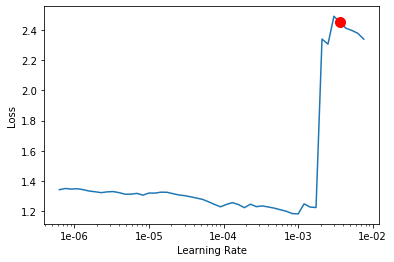

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
lr = learn.recorder.min_grad_lr

In [0]:
from fastai.callbacks import *
import numpy
import torch

In [0]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max'
                                      )
                    ]
                   )


epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.343376,0.379605,0.914893,0.731819,41:20
1,0.377598,0.388650,0.920925,0.741445,41:22
2,0.298302,0.359055,0.918821,0.738181,41:22
3,0.300098,0.357238,0.930759,0.753975,41:23
4,0.254020,0.354658,0.930326,0.751218,41:19


Better model found at epoch 0 with dice_multich value: 0.7318193912506104.
Better model found at epoch 1 with dice_multich value: 0.7414453029632568.
Better model found at epoch 3 with dice_multich value: 0.7539751529693604.
Buffered data was truncated after reaching the output size limit.

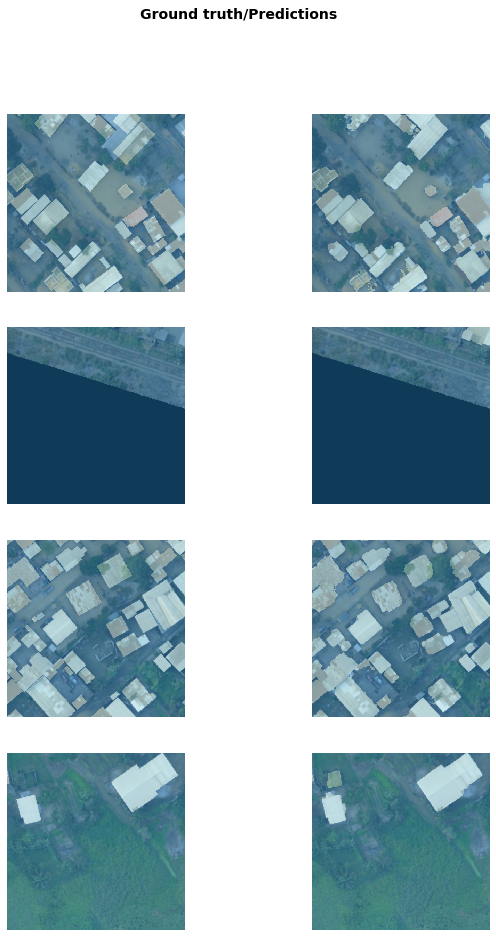

In [0]:
# Check some results visually
learn.show_results(rows=4, figsize=(10,15))

In [0]:
learn.export("export.pkl")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Unfreeze model and continue training**




we do this stap many times for differents learning rates such as 1e-04 , 1e-05, 1e-06

In [0]:
learn = load_learner('')
learn.data = data
learn.model.train()
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
from fastai.callbacks import *

In [0]:

learn.fit_one_cycle(20, max_lr=1e-5, 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich')
                    ]
                   )

In [0]:
learn.export('')

In [0]:
learn.show_results(rows=10 , figsize=(10,25))



# > **Post** **Processing**






In [0]:
!rm test.tgz
!wget https://drivendata-public-assets.s3.amazonaws.com/test.tgz
# Extract test files
!tar -xf test.tgz
!rm test.tgz

In [0]:
!pip install pystac
!pip install rasterio

In [0]:
from PIL import Image as PImage
from fastai.vision import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob

In [0]:
from pathlib import Path
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
TEST_PATH = Path('test')
PRED_PATH = Path('preds')
PRED_PATH.mkdir(exist_ok=True)
test_cat = Catalog.from_file(f'{TEST_PATH}/catalog.json')

If you have problem with ram , you must do it with batces. So you must run this  many time and change the value of start , end (etc. start = 0, end = 2000 -> restart runtime -> start = 2000, end = 4000 -> restart runtime -> ...) Files such as test are saved after restart runtime.

In [0]:
test_ims = glob.glob('test/*/*.tif')
print("Found ", len(test_ims), "images")

test_df = pd.DataFrame({
    'fn':test_ims,
    'id':[t.split('/')[1] for t in test_ims]
})
print(test_df.shape)
test_df.head()

In [0]:
idx = random.choice(range(len(test_df)))
im = PImage.open(test_df.fn.values[idx])
plt.imshow(np.array(im))

In [0]:
start = 0
end = 11481

In [0]:
src = (SegmentationItemList.from_df(path='', df=test_df[start:end], cols='fn')) # Did in two batches
learn = load_learner('') # Loads the exported learner from earlier
learn.data.add_test(src, tfms=None, tfm_y=False)
learn.data.batch_size = 4
preds, y = learn.get_preds(DatasetType.Test) # Careful with ram - do in batches if needed ()

In [0]:
from PIL import Image
for i in range(len(test_df)):
  if i%1000 == 0:
    print(i)
  if i >= start and i < end :
    im_id = test_df['id'].values[i]
    chip_id = im_id
    print(chip_id)

    pred_arr = np.array(preds[i-start][0])
    pred_arr = pred_arr > 0
    (pred_arr).astype(np.bool) 
    Image.fromarray(pred_arr).resize((1024, 1024), Image.NEAREST).save(f'{PRED_PATH}/{im_id}.tif', compression='tiff_deflate')


In [0]:
# Examine some outputs
idx = random.choice(range(len(test_df)))
print(idx)
img_id = test_df.id.values[idx]
pred_im = PImage.open('preds/'+str(img_id)+'.tif')
y_true = PImage.open(test_df.fn.values[idx])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Actual/Predicted')
ax1.imshow(np.array(y_true))
ax2.imshow(np.array(pred_im))

In [0]:
import os
for i in range(len(test_df)):
  im_id = test_df['id'].values[i]
  if not os.path.isfile('preds/'+str(im_id)+'.tif'):
    print(im_id)

In [0]:
!cd preds; zip -q -r submission.zip *.tif # Add to archive
!cp preds/submission.zip submission.zip # Move to root folder for download